**Imports**

In [1]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.calculations.calculations import calculate_energy
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.rulebased import rule_based_energy_flow

**Definition des Green Energy Ecosystems**

In [2]:
# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 
longitude=4.208611 
azimuth=180 
albedo=0.2 

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # MWh
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # MWh

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

**Vorbereiten des Wetterdatensatzes**

In [3]:
df_weather = get_weather()
if df_weather is None:
    print("Abbruch.")

df_weather.head()

,datetime,solarradiation,windspeed,temp,cloudcover,humidity,sealevelpressure
0,2025-05-24 23:00:00,0.0,25.2,14.8,100.0,91.43,1011.0
1,2025-05-25 00:00:00,0.0,28.2,14.7,100.0,91.54,1010.8
2,2025-05-25 01:00:00,0.0,29.5,14.7,100.0,90.51,1010.7
3,2025-05-25 02:00:00,0.0,27.5,14.7,100.0,89.82,1010.4
4,2025-05-25 03:00:00,0.0,25.4,14.7,100.0,90.14,1009.7


**Ausführen der Berechnungsfunktionen**

In [4]:
# Bedarf und Ertrag berechnen
df_energy = calculate_energy(
df_weather, 
solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines, 
yearly_demand, num_houses
)

**Plot der Energiedaten und relevanten Wetterdaten der letzten 7 Tage**

C:\Users\Julian\AppData\Local\Temp\ipykernel_13244\4202221731.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_plot = df_energy.copy().set_index("datetime").last("7D")


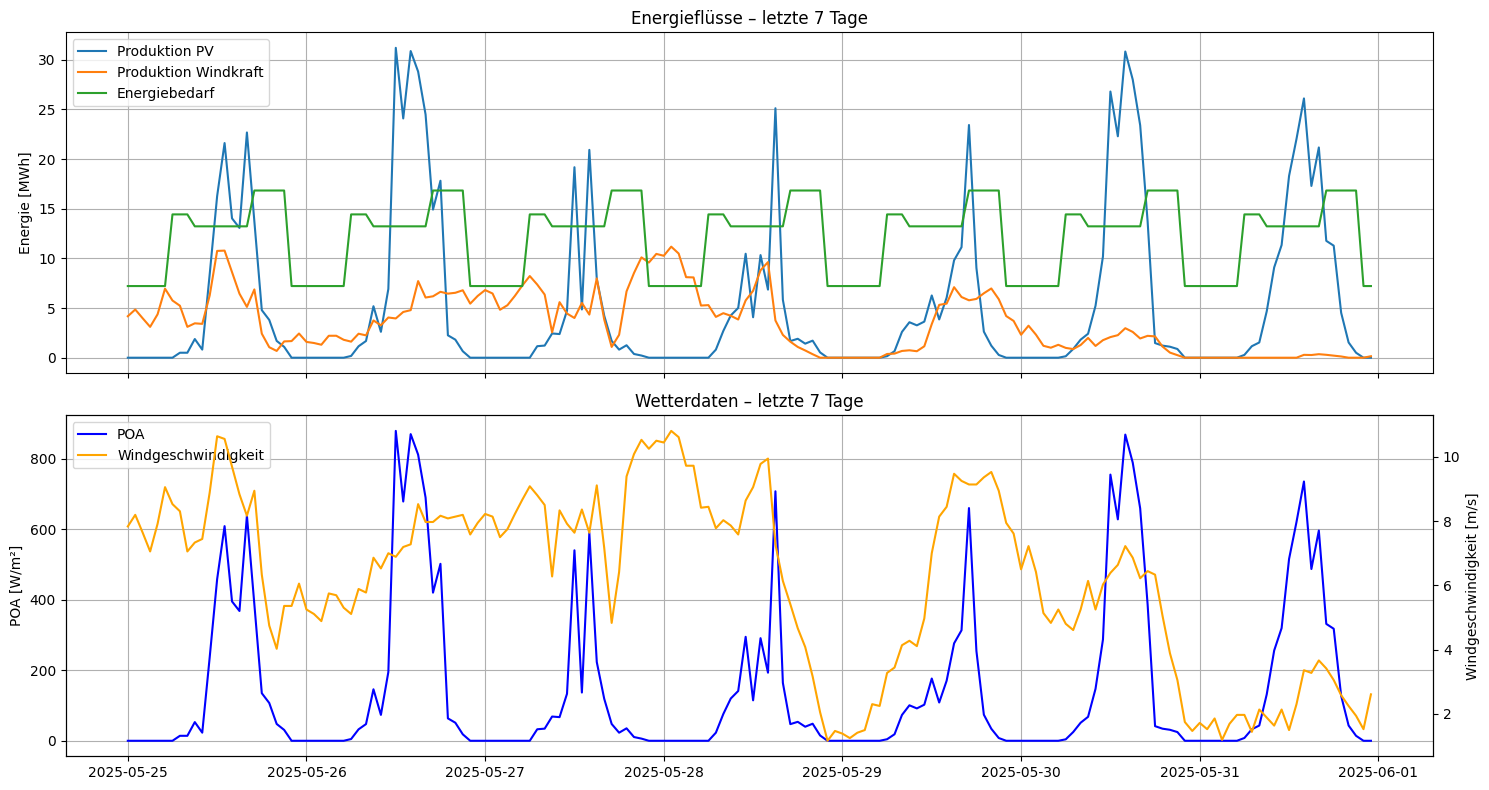

In [5]:
# Letzte 7 Tage extrahieren
df_plot = df_energy.copy().set_index("datetime").last("7D")

# Figure mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse – letzte 7 Tage")
ax1.legend()
ax1.grid(True)

# Wetterdaten
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten – letzte 7 Tage")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()


In [6]:
df_spot = get_spotprice()
if df_spot is None:
    print("Abbruch.")

df_spot.head()

,datetime,spotprice
0,2025-05-24 23:00:00,7.967
1,2025-05-25 00:00:00,2.382
2,2025-05-25 01:00:00,2.290
3,2025-05-25 02:00:00,1.439
4,2025-05-25 03:00:00,0.838


**Ausführen der regelbasierten und optimierten Funktion**

In [ ]:
# Optimierungsfunktionen
result_df_rule, total_cost_rule = rule_based_energy_flow(df_energy, df_spot, battery_capacity, initial_battery)
result_df_opt, total_cost_opt = optimize_energy_flow(df_energy, df_spot, battery_capacity, initial_battery)

⚙️ Verfügbare Solver: ['CBC', 'CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']
👉 Versuche Solver: GUROBI
✅ Solver erfolgreich: GUROBI
Optimierungsstatus: optimal


**Berechnung der Stromkosten**

In [ ]:
"""# Kostenberechnung
result_df_rule["costs"] = result_df_rule["grid_buy"] * 100
total_cost_rule = result_df_rule["costs"].sum()"""

**Ausgabe der wichtigsten KPIs zum quanitiativen Vergleich der Performance**

In [20]:
#Ausgaben 
print(f"Regelbasiert:")
print(f"Stromkosten: {total_cost_rule:.2f} €")
print("Netzbezug:", result_df_rule["grid_buy"].sum())
print("Gesamtladung Batterie:", result_df_rule["battery_charge"].sum())
print("Gesamtentladung Batterie:", result_df_rule["battery_discharge"].sum())

print(f"Optimiert:")
print(f"Stromkosten: {total_cost_opt:.2f} €")
print("Netzbezug:", result_df_opt["grid_buy"].sum())
print("Gesamtladung Batterie:", result_df_opt["battery_charge"].sum())
print("Gesamtentladung Batterie:", result_df_opt["battery_discharge"].sum())

Regelbasiert:
Stromkosten: 72291.93 €
Netzbezug: 841.1263442648068
Gesamtladung Batterie: 101.32892564460488
Gesamtentladung Batterie: 107.32892564460488
Optimiert:
Stromkosten: 84112.63 €
Netzbezug: 841.1263442648069
Gesamtladung Batterie: 129.19024177635703
Gesamtentladung Batterie: 135.19024177635703


**Plot der Energieflüsse zum qualitativen Vergleich der Performance**

In [ ]:
#Plots erstellen

# Zeitspalte parsen
result_df_opt["datetime"] = pd.to_datetime(result_df_opt["datetime"])
result_df_rule["datetime"] = pd.to_datetime(result_df_rule["datetime"])

# Filter: nur die ersten beiden Tage
start_time = result_df_opt["datetime"].min()
start_time = start_time + pd.Timedelta(days=1)
end_time = start_time + pd.Timedelta(days=3)

result_df_opt = result_df_opt[(result_df_opt["datetime"] >= start_time) & (result_df_opt["datetime"] < end_time)]
result_df_rule = result_df_rule[(result_df_rule["datetime"] >= start_time) & (result_df_rule["datetime"] < end_time)]

# Schriftgrößen definieren
label_fontsize = 20
tick_fontsize = 20
legend_fontsize = 20

# Plot erstellen
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Netzbezug
axs[0].plot(result_df_opt["datetime"], result_df_opt["grid_buy"], label="optimized", linewidth=2.5)
axs[0].plot(result_df_rule["datetime"], result_df_rule["grid_buy"], label="rulebased", color="black", linestyle="--", linewidth=2)
axs[0].set_ylabel("Grid electricity [MWh]", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# Curtailment vs. Feed-in
axs[1].plot(result_df_opt["datetime"], result_df_opt["curtailment"], label="optimized", color="orange", linewidth=2.5)
axs[1].plot(result_df_rule["datetime"], result_df_rule["grid_feed_in"], label="rulebased", color="black", linestyle="--", linewidth=2)
axs[1].set_ylabel("Feed-in [MWh]", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# Batteriezustand
axs[2].plot(result_df_opt["datetime"], result_df_opt["battery_state"], label="optimized", color="green", linewidth=2.5)
axs[2].plot(result_df_rule["datetime"], result_df_rule["battery_state"], label="rulebased", color="black", linestyle="--", linewidth=2)
axs[2].set_ylabel("SOC [MWh]", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

# Erzeugung und Verbrauch
axs[3].plot(result_df_opt["datetime"], result_df_opt["total_energy_production"], label="Energy generation", color="purple", linewidth=2.5)
axs[3].plot(result_df_opt["datetime"], result_df_opt["energy_demand"], label="Energy demand", linestyle="--", color="black", linewidth=2)
axs[3].set_ylabel("Energy quantity [MWh]", fontsize=label_fontsize)
axs[3].legend(fontsize=legend_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)

# Gemeinsame X-Achse
plt.xlabel("Date/time", fontsize=label_fontsize)
plt.tight_layout()
plt.show()